In [1]:
import numpy as np
from pldepth.data.dao.hr_wsi import HRWSITFDataAccessObject
from pldepth.data.io_utils import get_dataset_type_by_name
from pldepth.data.providers.hourglass_provider import HourglassLargeScaleDataProvider
from pldepth.data.sampling import ThresholdedMaskedRandomSamplingStrategy, InformationScoreBasedSampling
from pldepth.losses.losses_meta import DepthLossType
from pldepth.losses.nll_loss import HourglassNegativeLogLikelihood
from pldepth.models.PLDepthNet import get_pl_depth_net
from tensorflow import keras
from tensorflow.python.keras.callbacks import TerminateOnNaN, LearningRateScheduler
from pldepth.models.pl_hourglass import EffNetFullyFledged
from pldepth.losses.nll_loss import HourglassNegativeLogLikelihood

import tensorflow as tf

from pldepth.util.env import init_env
from pldepth.models.models_meta import ModelParameters, get_model_type_by_name
from pldepth.util.training_utils import LearningRateScheduleProvider

2021-11-23 21:45:48.874488: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-23 21:45:48.874519: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataset = "HR-WSI"

In [3]:
model1 = tf.keras.models.load_model('/home/praneeth/projects/thesis/git/bakup/PLDepth/pldepth/weights/150821-230138model_rnd_sampling.h5',
                                       custom_objects={'EffNetFullyFledged': EffNetFullyFledged},
                                                  compile=False)
model2 = tf.keras.models.load_model('/home/praneeth/projects/thesis/git/bakup/PLDepth/pldepth/weights/160821-022846mod_info_sampling3.h5',
                                       custom_objects={'EffNetFullyFledged': EffNetFullyFledged},
                                                  compile=False)

#model.summary()


2021-11-23 21:45:51.443689: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-23 21:45:51.444447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-23 21:45:51.707944: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-23 21:45:51.708000: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (praneeth-Inspiron-7572): /proc/driver/nvidia/version does not exist
2021-11-23 21:45:51.709567: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [4]:
model_input_shape = [448, 448, 3]
data_path = '/home/praneeth/projects/thesis/git/HR-WSI/'

dao = HRWSITFDataAccessObject(data_path, model_input_shape, seed=42)
val_imgs_ds, val_gts_ds, val_cons_masks = dao.get_validation_dataset()


In [5]:

vds = list(val_imgs_ds.as_numpy_iterator())
vgt = list(val_gts_ds.as_numpy_iterator())
test_img = vds[:50]
test_gt = vgt[:50]
np.array(test_gt[0]).shape

2021-11-23 21:45:55.094452: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-23 21:45:55.113203: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1800000000 Hz


(448, 448, 1)

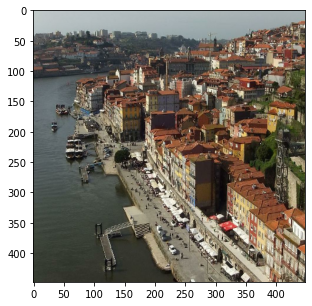

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(5,5)) 
plt.imshow(vds[3])

In [7]:
out1 = model1.predict(np.array([vds[3]]), batch_size=None)
out2 = model2.predict(np.array([vds[3]]), batch_size=None)

a = np.squeeze(out1)

a.shape

(448, 448)

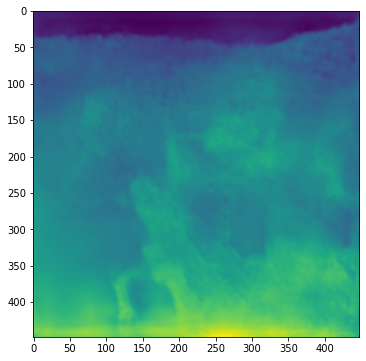

In [8]:
plt.figure(figsize=(6, 6)) 
plt.imshow(np.squeeze(out1))

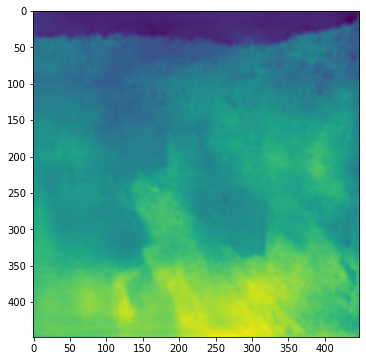

In [9]:
plt.figure(figsize=(6, 6)) 
plt.imshow(out2[0])

In [10]:
# idx = np.random.choice(list(range(448*448)), 10, replace=False)
# print(idx)
# idx0, idx1 = np.split(idx,2)
# print(idx0, idx1)

In [11]:
def ordinal_error(op, gt, imsize=(448,448), num=100):
    np.random.seed(10)
    idx = np.random.choice(list(range(imsize[0]*imsize[1])), num*2, replace=False)  # add seed or np random state
    idx0, idx1 = np.split(idx, 2)
    op_flat = op.flatten()
    gt_flat = gt.flatten()
    
    out_order = np.greater(op_flat[idx0], op_flat[idx1])
    gt_order = np.greater(gt_flat[idx0], gt_flat[idx1])
    accuracy = np.equal(out_order, gt_order).sum()/num
    return 1 - accuracy

In [12]:
err_vec1 = []
for i in  range(len(test_img)):
    pred = model1.predict(np.array([test_img[i]]), batch_size=None)
    err = ordinal_error(pred[0], test_gt[i])
    err_vec1.append(err)
    
np.mean(err_vec1)

0.24200000000000002

In [13]:
err_vec2 = []
for i in  range(len(test_img)):
    pred = model2.predict(np.array([test_img[i]]), batch_size=None)
    err = ordinal_error(pred[0], test_gt[i])
    err_vec2.append(err)
    
np.mean(err_vec2)


0.253

## DCG Implementation

In [17]:
def calcDCG(rel_list):
    # choose list size
    # get sample lists, order acc to op
    # compute dcg
    # compute ndcg by computing dcg for same using gt
    log_i_1 = np.log2(np.arange(np.shape(rel_list)[0])+2)
    return (rel_list / log_i_1).sum()
    
    
    
def calc_d(op, gt, imsize=(224,224), list_size=200):
    op = cv2.normalize(op, None, 0, 1, cv2.NORM_MINMAX)
    op_flat = op.flatten()
    gt_flat = gt.flatten()
    np.random.seed(69)
    ids = np.random.choice(np.arange(imsize[0]*imsize[1]), size=list_size, replace=False)
    sample_dist_list = op_flat[ids]
    sorted_dist_list = np.sort(sample_dist_list)
    
    sorted_gt_list = np.sort(gt_flat[ids])
    
    rel_dist_list = 1 / (sorted_dist_list + 1)
    
    rel_gt = 1/(sorted_gt_list + 1)

    dcg = calcDCG(rel_dist_list)
    gt_dcg = calcDCG(rel_gt)
    return dcg / gt_dcg

    
def dcg_metric(model, test_im, test_gt, list_size=200):
    dcg = []
    for i in range(len(test_im)):
        pred = model.predict(np.array([test_im[i]]), batch_size=None)
        dcg_i = calc_d(pred[0], test_gt[i])
        dcg.append(dcg_i)
    
    return np.mean(dcg)
    
    
    
    

In [20]:
def auto_canny(image, sigma=1.5):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("threshold is ", lower, "and", upper)
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

In [ ]:
def depth_edge_metric(op, gt, imsize=(224,224)):
    Y_bin = auto_canny(op)
    Y_star_bin = auto_canny(gt)
    
    e = cv2.distanceTransform(Y_bin, cv2.DIST_L2, 3)
    e[e>10] = 0  # dist > 10 = 0
    
    e_star = cv2.distanceTransform(Y_star_bin, cv2.DIST_L2, 3)
    e_star[e_star>10] = 0  # dist > 10 = 0
    
    
    
    numerator1 = np.sum(e_star * Y_bin)
    denominator1 = np.sum(Y_bin)
    depth_boundary_error = numerator1/denominator1
    
    numerator2 = np.sum(e * Y_star_bin)
    denominator2 = np.sum(Y_star_bin)
    
    comleteness_error = numerator2/denominator2
    
    return depth_boundary_error, comleteness_error
    
    
    
def calc_depth_metrics(model, test_im, test_gt):
    de = []
    dc = []
    for i in range(len(test_im)):
        pred = model.predict(np.array([test_im[i]]), batch_size=None)
        de_i, dc_i = depth_edge_metric(pred[0], test_gt[i])
        de.appenx(de_i)
        dc.append(dc_i)
    
    return np.mean(de), np.mean(dc)
    






In [19]:
# pred = model2.predict(np.array([test_img[1]]), batch_size=None)
# gt = test_gt[1]
# calc_d(pred, gt, list_size=10)

dcg_metric(model2, test_img, test_gt)

0.8820724568353101

In [45]:
# a= np.zeros((10,10), dtype = np.uint8)
# a[3:6, 5:7] = 1
# cv2.distanceTransform(a, cv2.DIST_L2, 3)

import cv2 
import numpy as np

testim = np.zeros((11,11), dtype = np.uint8)
testim[2,:] = 255
#testim[3,3] = 0
print(testim)
dist = cv2.distanceTransform(testim, cv2.DIST_L2, 5)
print(dist)

[[  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255 255 255 255]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
plt.imshow(cv2.normalize(out1[0], None, 0,255, cv2.NORM_MINMAX), cmap='gray')

In [ ]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("threshold is ", lower, "and", upper)
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged


def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=3.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [ ]:
img_o = vds[3]
img_o = cv2.cvtColor(img_o, cv2.COLOR_RGB2GRAY)
img_o = cv2.normalize(img_o, None, 0 ,255, cv2.NORM_MINMAX).astype(np.uint8)
img_o = cv2.medianBlur(img_o,15)  #cv2.blur(img_o, ksize=(7,7))
# Using the Canny filter to get contours
edges_o = cv2.Canny(img_o, 50, 140)
in_edges= auto_canny(img_o)



plt.imshow(in_edges, cmap='gray')

In [ ]:

im_out = out1[0]
im_out = cv2.normalize(im_out, None, 0,255, cv2.NORM_MINMAX)
im_sharp = unsharp_mask(im_out)
cv2.normalize(im_sharp, None, 0 , 255, cv2.NORM_MINMAX)

pred_edges =  auto_canny(im_sharp)
plt.imshow(pred_edges, cmap='gray')

In [ ]:
from skimage.metrics import hausdorff_distance
import warnings
import numpy as np
from scipy.spatial import cKDTree

def splitImage(img, n=14):
    """ image is broken into nxn pieces
    """
    split = [0]*(n*n) #np.zeros(n*n)
    n = int(img.shape[0]/n)
    i=0
    for r in range(0,img.shape[0],n):
        for c in range(0,img.shape[1],n):
            sm_img = img[r:r+n, c:c+n]
            split[i] = sm_img
            i += 1
            
    #plt.imshow(sm_img, cmap= 'gray')
    return np.array(split)
    
    
def hausdorf_dist(i1, i2):
    """ return hausdorf dist + the points at max distance"""
    
    return hausdorff_distance(i1, i2)
    
    
    

def hausdorff_pair(image0, image1):
    """ Returns the coordinates of the points at hausdorff distance"""

    a_points = np.transpose(np.nonzero(image0))
    b_points = np.transpose(np.nonzero(image1))

    # If either of the sets are empty, there is no corresponding pair of points
    if len(a_points) == 0 or len(b_points) == 0:
        warnings.warn("One or both of the images is empty.", stacklevel=2)
        return (), ()

    nearest_dists_from_b, nearest_a_point_indices_from_b = cKDTree(a_points).query(b_points)
    nearest_dists_from_a, nearest_b_point_indices_from_a = cKDTree(b_points) \
        .query(a_points)

    max_index_from_a = nearest_dists_from_b.argmax()
    max_index_from_b = nearest_dists_from_a.argmax()

    max_dist_from_a = nearest_dists_from_b[max_index_from_a]
    max_dist_from_b = nearest_dists_from_a[max_index_from_b]

    if max_dist_from_b > max_dist_from_a:
        return a_points[max_index_from_b], \
            b_points[nearest_b_point_indices_from_a[max_index_from_b]]
    else:
        return a_points[nearest_a_point_indices_from_b[max_index_from_a]], \
            b_points[max_index_from_a]
            
            
    

In [ ]:

def active_sampling(in_edges, pred_edges):

    split_in = splitImage(in_edges)
    split_pred = splitImage(pred_edges)
    dist = np.zeros(split_in.shape[0])
    pts =  np.zeros((split_in.shape[0],2))

    for i in range(split_in.shape[0]):
        hd = hausdorf_dist(split_in[i], split_pred[i])
        pt_in , pt_pred = hausdorff_pair(split_in[i], split_pred[i])
        #print(pt_in)

        if not len(pt_in) == 0:
            st_r = (int(i/14) * split_in.shape[1]) + pt_in[0]
            st_c = int((i % 14) * split_in.shape[2] + pt_in[1])
            dist[i] = hd
            pts[i] = np.array([st_r, st_c])

        else:
            st_r = int(i/14) * int(split_in.shape[1]) 
            st_c = int((i % 14)* split_in.shape[2]) 
            dist[i] = 1000
            pts[i] = np.array([st_r, st_c])


    #sorting the hausdorf dist
    idx = np.argsort(dist)
    dist = dist[idx]
    pts = pts[idx]
    pos = pts[:,0]*448 + pts[:,1]

    return pos.astype(np.uint32), pts.astype(np.uint32)

#pos, pos_xy = active_sampling(in_edges, pred_edges)
    

In [ ]:


def oracle(img, img_gts, pos_xy):
    list_size=5
    result_buffer = np.zeros([int(pos_xy.shape[0]/list_size), list_size, 2], dtype=np.float32)
    buf = np.zeros((list_size,2))
    
    np.random.shuffle(pos_xy)
    j=0
    for i in range(0, pos_xy.shape[0]-list_size, list_size):
        
        for k in range(list_size):
            buf[k,0] = pos_xy[i+k,0]*448 + pos_xy[i+k,1]
            buf[k,1] = gts[tuple(pos[i+k])]
        
        result_buffer[j] = buf
        j+=1
        
    return result_buffer
    
    
    
def active_learning_data_provider(img_arr, img_gts_arr, model, batch_size):
    
    a_ds_in = list(img_arr.as_numpy_iterator())
    a_gt_in = list(img_gts_arr.as_numpy_iterator())
    
    a_ds_out = []
    sample_lists = np.zeros([len(a_ds_in), 196, 5])   # samples per img(14x14), ranking size
    
    i=0
    for img_in, gts_in in zip(a_ds_in, a_gt_in):
        
        img_o = cv2.cvtColor(img_in, cv2.COLOR_RGB2GRAY)
        img_o = cv2.normalize(img_o, None, 0 ,255, cv2.NORM_MINMAX).astype(np.uint8)
        img_o = cv2.medianBlur(img_o,15)  #cv2.blur(img_o, ksize=(7,7))
        # Using the Canny filter to get contours
        in_edges= auto_canny(img_o)
        
        pred_ele = model.predict(np.array([img_in]), batch_size=None)
        pred_ele = np.squeeze(pred_ele)
        pred_im_out = cv2.normalize(pred_ele, None, 0,255, cv2.NORM_MINMAX)
        pred_im_sharp = unsharp_mask(im_out)

        pred_edges =  auto_canny(pred_im_sharp)
        
        pos, pos_xy = active_sampling(in_edges, pred_edges)
        
        sample_lists[i] = oracle(img_in, img_gts, pos_xy)
        
    sample_list_tf = tf.data.Dataset.from_tensor_slices(sample_lists)
    
    
    
    return tf.data.Dataset.zip((img_arr, sample_list_tf)).batch(batch_size, drop_remainder=True)

        

    
    
    
    

In [ ]:
448/32